# GLCP

In [1]:
from shiori.utils.viewer import set_plot_params, sns, plt
from shiori.utils.path import ProjectPath
from pathlib import Path
import numpy as np
import cv2
set_plot_params()
name = Path().cwd().name + "/GLCP"
proj = ProjectPath(save_dst=name)
save_dir = proj.save_dir
save_dir.mkdir(parents=True, exist_ok=True)
plt.rcParams.update({
    "text.usetex": True,               # LaTeXを使う
    "font.family": "Arial",            # セリフ体
    "font.serif": ["Computer Modern"], # LaTeX標準フォント
})


In [2]:
def extract_endpoints(skel: np.ndarray) -> np.ndarray:
    bin_skel = (skel > 0).astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    neighbor_count = cv2.filter2D(bin_skel, -1, kernel)
    endpoints = np.logical_and(bin_skel == 1, neighbor_count == 2)
    return endpoints.astype(np.uint8)

In [3]:
# 1. ダミーのスケルトン画像を作成
H, W = 256, 256

In [4]:
skel1 = np.zeros((H, W), dtype=np.uint8)
cv2.line(skel1, (120, 200), (120, 80), 255, 1)
cv2.line(skel1, (120, 120), (180, 60), 255, 1)
pts = np.array([[50, 50], [70, 70], [90, 60], [110, 65]], np.int32).reshape((-1, 1, 2))
cv2.polylines(skel1, [pts], False, 255, 1)
endpoints1 = extract_endpoints(skel1)
vis1 = cv2.cvtColor(skel1, cv2.COLOR_GRAY2BGR)
ys, xs = np.where(endpoints1 == 1)
for x, y in zip(xs, ys):
    cv2.circle(vis1, (x, y), 4, (0, 255, 255), thickness=-1)  # 黄(BGR)

In [5]:
skel2 = np.zeros((H, W), dtype=np.uint8)
cv2.line(skel2, (120, 200), (120, 80), 255, 1)
cv2.line(skel2, (120, 120), (180, 60), 255, 1)
pts = np.array([[50, 50], [70, 70], [90, 60], [110, 65], [120, 80]], np.int32).reshape((-1, 1, 2))
cv2.polylines(skel2, [pts], False, 255, 1)
endpoints2 = extract_endpoints(skel2)
vis2 = cv2.cvtColor(skel2, cv2.COLOR_GRAY2BGR)
ys, xs = np.where(endpoints2 == 1)
for x, y in zip(xs, ys):
    cv2.circle(vis2, (x, y), 4, (0, 255, 255), thickness=-1)  # 黄(BGR)

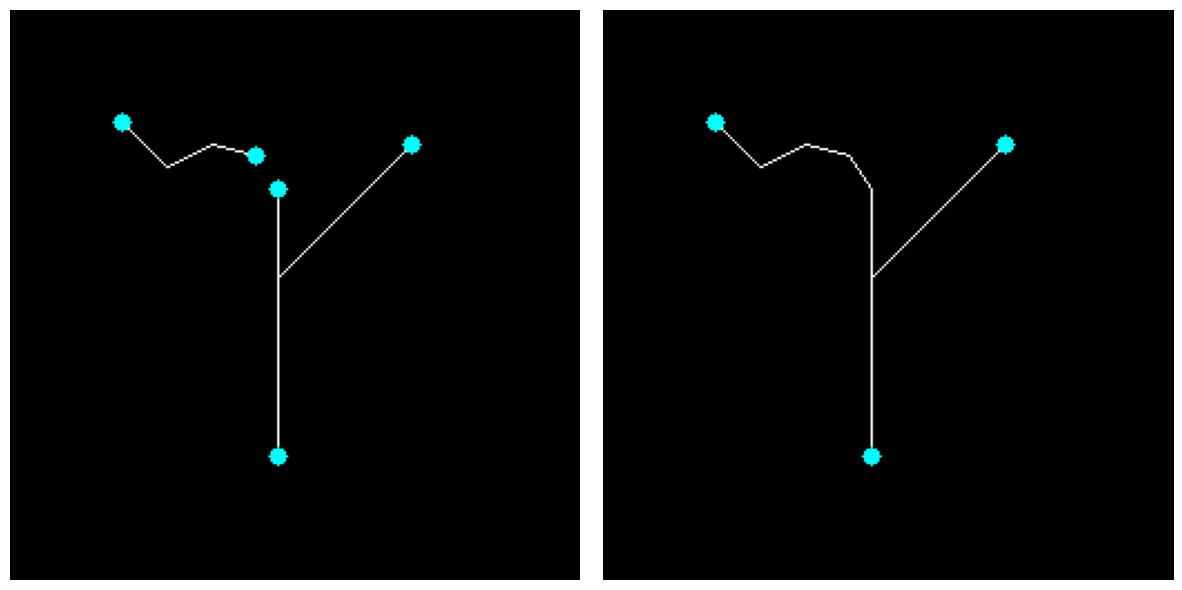

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(vis1)
plt.axis("off")
plt.subplot(122)
plt.imshow(vis2)
plt.axis("off")
plt.tight_layout()
plt.savefig(save_dir.joinpath("endpoints.png"), dpi=300, facecolor="white")
plt.show()

# 不連続点候補の膨張

In [7]:
def get_rectangle(center, wx=5, wy=5):
    x, y = center
    pt1 = (int(x - wx/2), int(y-wy/2))
    pt2 = (int(x + wx/2), int(y+wy/2))
    return pt1, pt2


In [8]:
import warnings
warnings.filterwarnings("ignore")

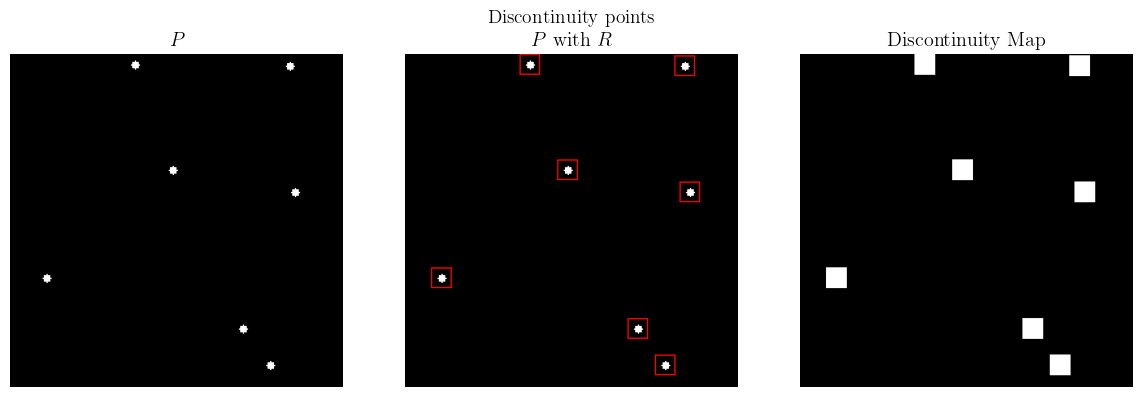

In [10]:
H, W = 256, 256
n_points = 7
wx = wy = wz = 5
canvas1 = np.zeros((H, W, 3), dtype=np.uint8)
canvas2 = np.zeros((H, W, 3), dtype=np.uint8)
canvas3 = np.zeros((H, W, 3), dtype=np.uint8)
random_points = np.random.randint(0, 256, 2*n_points)
Rs = np.split(random_points, n_points)
for ri in Rs:
    cv2.circle(canvas1, ri, 3, (255, 255, 255), thickness=-1)
    cv2.circle(canvas2, ri, 3, (255, 255, 255), thickness=-1)
    pt1, pt2 = get_rectangle(ri, wx=15, wy=15)
    cv2.rectangle(canvas1, pt1, pt2, color=(255, 0, 0), thickness=1)
    cv2.rectangle(canvas3, pt1, pt2, color=(255, 255, 255), thickness=-1)

plt.figure(figsize=(12,4))
plt.suptitle("Discontinuity points", fontsize=14)
plt.subplot(131)
plt.imshow(canvas2)
plt.title("$P$")
plt.axis(False)
plt.subplot(132)
plt.title("$P$ with $R$")
plt.imshow(canvas1)
plt.axis(False)
plt.subplot(133)
plt.title("Discontinuity Map")
plt.imshow(canvas3)
plt.axis(False)
plt.tight_layout()
# plt.savefig(save_dir.joinpath("R.png"), dpi=300, facecolor="white")
plt.show()

In [55]:
from skimage.morphology import skeletonize

In [218]:
img_path = Path(save_dir.joinpath("Fg_raw.png"))
Fs = cv2.imread(img_path, 0)
Fs = cv2.resize(Fs, (256,256))
Fs = np.where(Fs>0, 255, 0).astype(np.uint8)
Fs = cv2.GaussianBlur(Fs, ksize=(3,3), sigmaX=0)
Fs = np.where(Fs>0, 255, 0).astype(np.uint8)
Fs = cv2.rectangle(Fs, (100, 75), (150, 100), color=0, thickness=-1)

In [219]:
skel = skeletonize(Fs)
Sg_hat = np.where(skel==True, 255, 0).astype(np.uint8)
Sg_hat.shape

(256, 256)

In [220]:
Sg_hat = cv2.cvtColor(Sg_hat, cv2.COLOR_GRAY2BGR)
Fs = cv2.cvtColor(Fs, cv2.COLOR_GRAY2BGR)

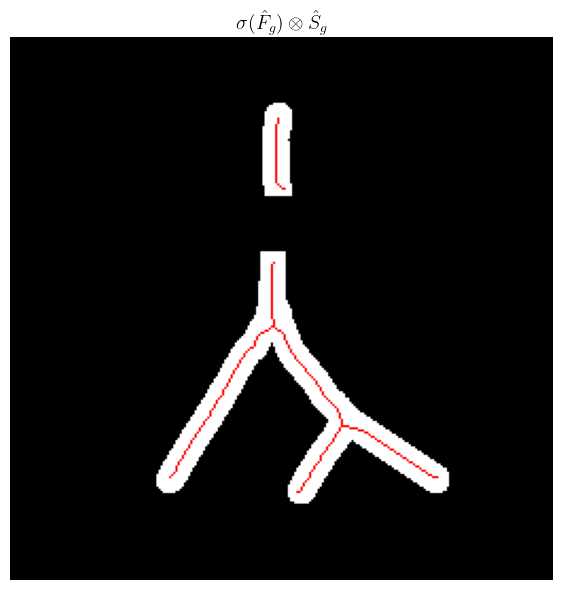

In [ ]:
blend = np.where(Sg_hat>0, (255,0,0), Fs)
plt.figure(figsize=(6,6))
plt.imshow(blend)
plt.axis("off")
plt.savefig(save_dir / "Fghat_Sghat.png", dpi=300, facecolor="white")
plt.title("$\sigma(\hat F_g) \otimes \hat S_g$")
plt.tight_layout()
plt.show()